# Simple 2D Sparse GP
We will test to ensure that our sparse GP implementation works correctly in this notebook.

## Generate Syntethic Data
We generate a simple dataset for testing with inputs in the range [0, 200]. We'll use a sinusoidal function with some noise added.

In [1]:
import numpy as onp
import matplotlib.pyplot as plt

from sparse_gp import *
from plots import *

prng_key = random.key(0)

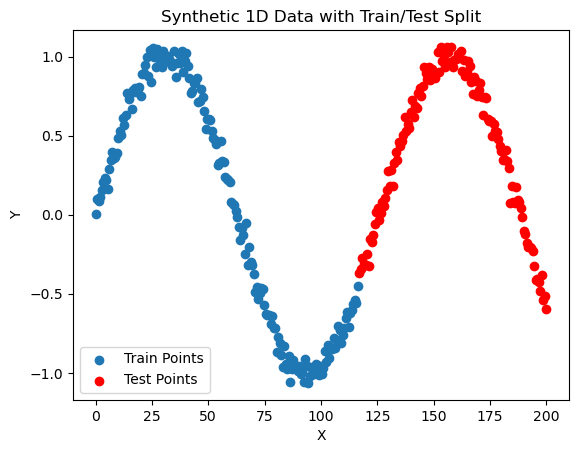

In [2]:
# Inputs
X = onp.linspace(0, 200, 300).reshape(-1, 1)

# Outputs: Sine function with noise
Y = onp.sin(X * 0.05) + 0.05 * onp.random.normal(size=X.shape)

# Training and testing split
X_train, Y_train = X[:175], Y[:175]
X_test, Y_test = X[175:], Y[175:]

# Plot data
plt.scatter(X_train, Y_train, label="Train Points")
plt.scatter(X_test, Y_test, label="Test Points", color="red")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.title("Synthetic 1D Data with Train/Test Split")
plt.show()

# Test Experiment 1
Test on 20 inducing points.

## Parameter Initialization

In [3]:
# Initialize PRNG
init_prng(0)

# Initialize inducing points as a subset of X_train
Z = initialize_inducing_points(X_train, num_inducing=20)

# Define a function to initialize hyperparameters for the combined kernel
def random_init_combined_hyperparams(X_train):
    # Determine the number of input dimensions from X_train
    dims = X_train.shape[1]
    
    # Three initial weights in log space for unconstrained optimization (converted to float)
    initial_weights = [0, 0, 0, 0, 0]
    
    # Initial hyperparameters for each kernel
    hyperparams_sqexp = [0.1, 1.0, 10.0]        # [noise_variance, signal_variance, length_scale]
    hyperparams_linear = [0.1, 1.0]             # [noise_variance, signal_variance]
    hyperparams_matern = [0.1, 1.0, 10.0]       # [noise_variance, signal_variance, length_scale]
    hyperparams_sinusoidal = [0.1, 1.0, 10.0, 1.0]  # [noise_variance, signal_variance, period, length_scale]

    # Initialize spectral mixture hyperparameters
    num_mixtures = 2
    hyperparams_spectralmixture = [0.1]  # Start with noise_variance and number of mixtures

    for _ in range(num_mixtures):
        weight = 1 / num_mixtures  # Equal weight for each mixture initially
        mean = random.uniform(grab_prng(), shape=(dims,), minval=-5, maxval=5).tolist()
        variance = random.uniform(grab_prng(), shape=(dims,), minval=-5, maxval=5).tolist()
        hyperparams_spectralmixture.append(weight)  # Add weight
        hyperparams_spectralmixture.extend(mean)  # Add flattened mean
        hyperparams_spectralmixture.extend(variance)  # Add flattened variance
    #

    # Concatenate all hyperparameters
    initial_params = (
        initial_weights +
        hyperparams_sqexp +
        hyperparams_linear +
        hyperparams_matern +
        hyperparams_sinusoidal +
        hyperparams_spectralmixture
    )
    
    return np.array(initial_params, dtype=np.float32)
#


# Initialize hyperparameters in the unconstrained space
unconstrained_hyperparams_init = random_init_combined_hyperparams(X_train)

## Define the Optimization Loop for ELBO

In [4]:
# Set the gradient ascent step size and number of steps
step_size = 5e-3
num_steps = 500

# Optimize ELBO using the empirical Bayes function
optimized_hyperparams, final_elbo, history = empirical_bayes(X_train, Y_train, Z, unconstrained_hyperparams_init, step_size, num_steps)

print("Optimized Hyperparameters:", optimized_hyperparams)
print("Final ELBO Value:", final_elbo)

Step 0, ELBO: -245.0050252440471
Step 10, ELBO: -229.68239311670303
Step 20, ELBO: -215.64443032227737
Step 30, ELBO: -202.21324709528002
Step 40, ELBO: -190.21054977246717
Step 50, ELBO: -179.69017057172942
Step 60, ELBO: -170.53622840912055
Step 70, ELBO: -162.14933637045786
Step 80, ELBO: -151.7418652508276
Step 90, ELBO: -125.77345131513357
Step 100, ELBO: -108.37030916181567
Step 110, ELBO: -92.60091316779912
Step 120, ELBO: -77.46852677186187
Step 130, ELBO: -63.02292525384772
Step 140, ELBO: -49.45148677064441
Step 150, ELBO: -37.005606247806384
Step 160, ELBO: -25.964316577219847
Step 170, ELBO: -16.58290297021466
Step 180, ELBO: -9.023821826902719
Step 190, ELBO: -3.291801047421103
Step 200, ELBO: 0.7894178529538465
Step 210, ELBO: 3.535055073105582
Step 220, ELBO: 5.310356882056254
Step 230, ELBO: 6.4443177851173346
Step 240, ELBO: 7.183844762726579
Step 250, ELBO: 7.690501530744115
Step 260, ELBO: 8.060053089350674
Step 270, ELBO: 8.34578996333667
Step 280, ELBO: 8.576612842

In [5]:
# Total noise variance
total_noise = np.sum(np.array([optimized_hyperparams[i] for i in [5, 8, 10, 13, 17]]))
print("\nTotal noise:", total_noise)


Total noise: 0.005223619


## Predict and Plot the Results

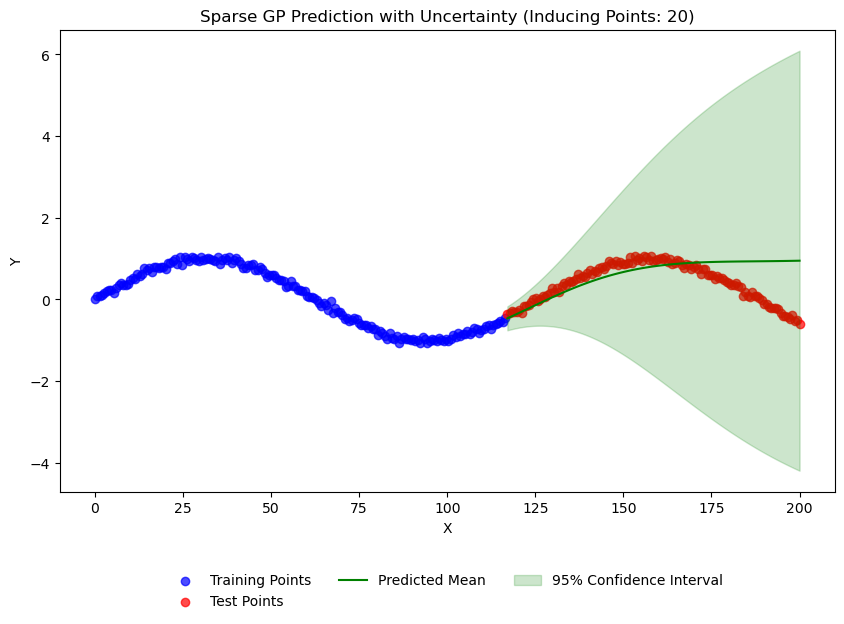

In [6]:
plot_sparse_gp_with_uncertainty(X_train, Y_train, X_test, Y_test, Z, optimized_hyperparams, sparse_gp_posterior_predictive, False)

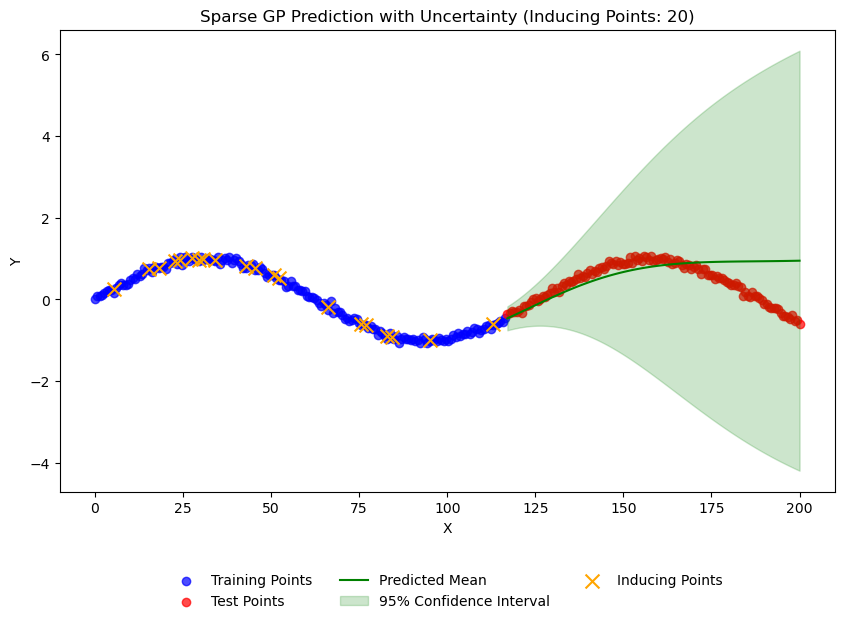

In [7]:
plot_sparse_gp_with_uncertainty(X_train, Y_train, X_test, Y_test, Z, optimized_hyperparams, sparse_gp_posterior_predictive)

In [8]:
# Extract weights
weights = optimized_hyperparams[:5]
weight_percentages = (weights / np.sum(weights)) * 100

# Print the weights
print("Kernel Weights:")
print(f"Kernel 1 (Squared-Exponential): {weights[0]:.4f}")
print(f"Kernel 2 (Linear): {weights[1]:.4f}")
print(f"Kernel 3 (Matérn): {weights[2]:.4f}")
print(f"Kernel 4 (Sinusoidal): {optimized_hyperparams[3]:.4f}")
print(f"Kernel 5 (Spectral Mixture): {optimized_hyperparams[4]:.4f}")

# Print weights as percentages for each kernel
print("\nKernel Weights as Percentages:")
print(f"Kernel 1 (Squared-Exponential): {weight_percentages[0]:.2f}%")
print(f"Kernel 2 (Linear): {weight_percentages[1]:.2f}%")
print(f"Kernel 3 (Matérn): {weight_percentages[2]:.2f}%")
print(f"Kernel 4 (Sinusoidal): {weight_percentages[3]:.2f}%")
print(f"Kernel 5 (Spectral Mixture): {weight_percentages[4]:.2f}%")

# Print other hyperparameters for each kernel
print("\nOther Hyperparameters:")
print(f"Kernel 1 - Noise Variance: {optimized_hyperparams[5]:.4f}")
print(f"Kernel 1 - Signal Variance: {optimized_hyperparams[6]:.4f}")
print(f"Kernel 1 - Length Scale: {optimized_hyperparams[7]:.4f}")
print(f"Kernel 2 - Noise Variance: {optimized_hyperparams[8]:.4f}")
print(f"Kernel 2 - Signal Variance: {optimized_hyperparams[9]:.4f}")
print(f"Kernel 3 - Noise Variance: {optimized_hyperparams[10]:.4f}")
print(f"Kernel 3 - Signal Variance: {optimized_hyperparams[11]:.4f}")
print(f"Kernel 3 - Length Scale: {optimized_hyperparams[12]:.4f}")
print(f"Kernel 4 - Noise Variance: {optimized_hyperparams[13]:.4f}")
print(f"Kernel 4 - Signal Variance: {optimized_hyperparams[14]:.4f}")
print(f"Kernel 4 - Period: {optimized_hyperparams[15]:.4f}")
print(f"Kernel 4 - Length Scale: {optimized_hyperparams[16]:.4f}")
print(f"Kernel 5 - Noise Variance: {optimized_hyperparams[17]:.4f}")

# Print rest of the hyperparameters for the spectral mixture kernel
dim = X_train.shape[1]
i = 18
mixture_count = 1
while i < len(optimized_hyperparams):
    print(f"\nSpectral Mixture Kernel - Mixture {mixture_count}:")
    print(f"Weight: {optimized_hyperparams[i: i + 1][0]:.4f}")
    print(f"Means: {optimized_hyperparams[i + 1: i + 1 + dim]}")
    print(f"Variances: {optimized_hyperparams[i + 1 + dim: i + 1 + 2 * dim]}")
    i += 1 + 2 * dim
    mixture_count += 1
#

print(optimized_hyperparams)

Kernel Weights:
Kernel 1 (Squared-Exponential): 0.8754
Kernel 2 (Linear): 0.5353
Kernel 3 (Matérn): 0.7798
Kernel 4 (Sinusoidal): 0.7798
Kernel 5 (Spectral Mixture): 0.0129

Kernel Weights as Percentages:
Kernel 1 (Squared-Exponential): 29.34%
Kernel 2 (Linear): 17.94%
Kernel 3 (Matérn): 26.14%
Kernel 4 (Sinusoidal): 26.14%
Kernel 5 (Spectral Mixture): 0.43%

Other Hyperparameters:
Kernel 1 - Noise Variance: 0.0010
Kernel 1 - Signal Variance: 2.3796
Kernel 1 - Length Scale: 2980.6055
Kernel 2 - Noise Variance: 0.0010
Kernel 2 - Signal Variance: 1.4550
Kernel 3 - Noise Variance: 0.0010
Kernel 3 - Signal Variance: 2.1196
Kernel 3 - Length Scale: 22026.4648
Kernel 4 - Noise Variance: 0.0010
Kernel 4 - Signal Variance: 2.1196
Kernel 4 - Period: 22026.4648
Kernel 4 - Length Scale: 2.7187
Kernel 5 - Noise Variance: 0.0010

Spectral Mixture Kernel - Mixture 1:
Weight: 0.1024
Means: [1.495]
Variances: [57.077705]

Spectral Mixture Kernel - Mixture 2:
Weight: 0.3430
Means: [2.8812811]
Variances

## NLPD

In [9]:
train_nlpd = calculate_nlpd(X_train, Y_train, Z, optimized_hyperparams, sparse_gp_posterior_predictive, X_train, Y_train)
test_nlpd = calculate_nlpd(X_test, Y_test, Z, optimized_hyperparams, sparse_gp_posterior_predictive, X_train, Y_train)

print(f"Train NLPD: {train_nlpd:.4f}")
print(f"Test NLPD: {test_nlpd:.4f}")

Train NLPD: -1.0430
Test NLPD: 1.5775


## MSE


In [10]:
Y_pred, _ = sparse_gp_posterior_predictive(X_test, X_train, Y_train, Z, optimized_hyperparams)
mse = calculate_mse(Y_test, Y_pred) 
print(f"MSE: {mse:.4f}")

MSE: 0.3129


## ELBO Maximization

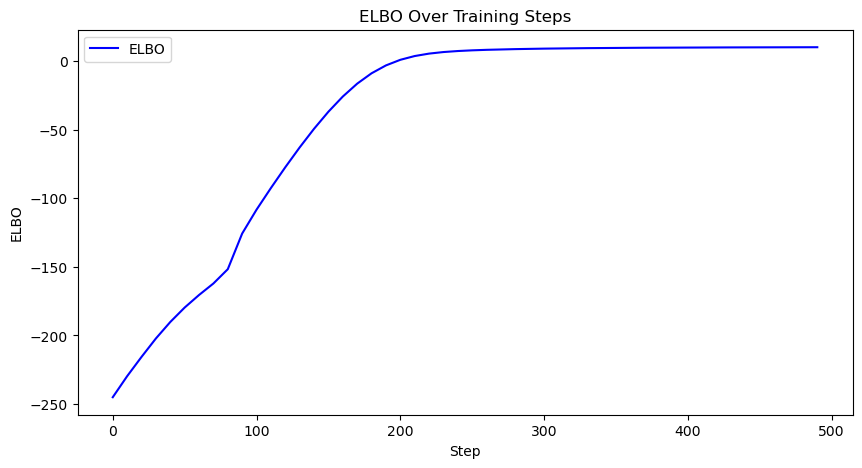

In [11]:
plot_elbo(history)

## Kernel Hyperparameters

Unchanged Hyperparameters:
 - Length Scale (Matern)
 - Length Scale (Sinusoidal)
 - SM Mean 2, Dim 1
 - SM Variance 2, Dim 1
 - SM Weight 3
 - SM Mean 3, Dim 1
 - SM Variance 3, Dim 1
 - SM Weight 4
 - SM Mean 4, Dim 1
 - SM Variance 4, Dim 1
 - SM Weight 5
 - SM Mean 5, Dim 1
 - SM Variance 5, Dim 1
 - SM Weight 6
 - SM Mean 6, Dim 1
 - SM Variance 6, Dim 1
 - SM Weight 7
 - SM Mean 7, Dim 1
 - SM Variance 7, Dim 1
 - SM Weight 8
 - SM Mean 8, Dim 1
 - SM Variance 8, Dim 1
 - SM Weight 9
 - SM Mean 9, Dim 1
 - SM Variance 9, Dim 1
 - SM Weight 10
 - SM Mean 10, Dim 1
 - SM Variance 10, Dim 1


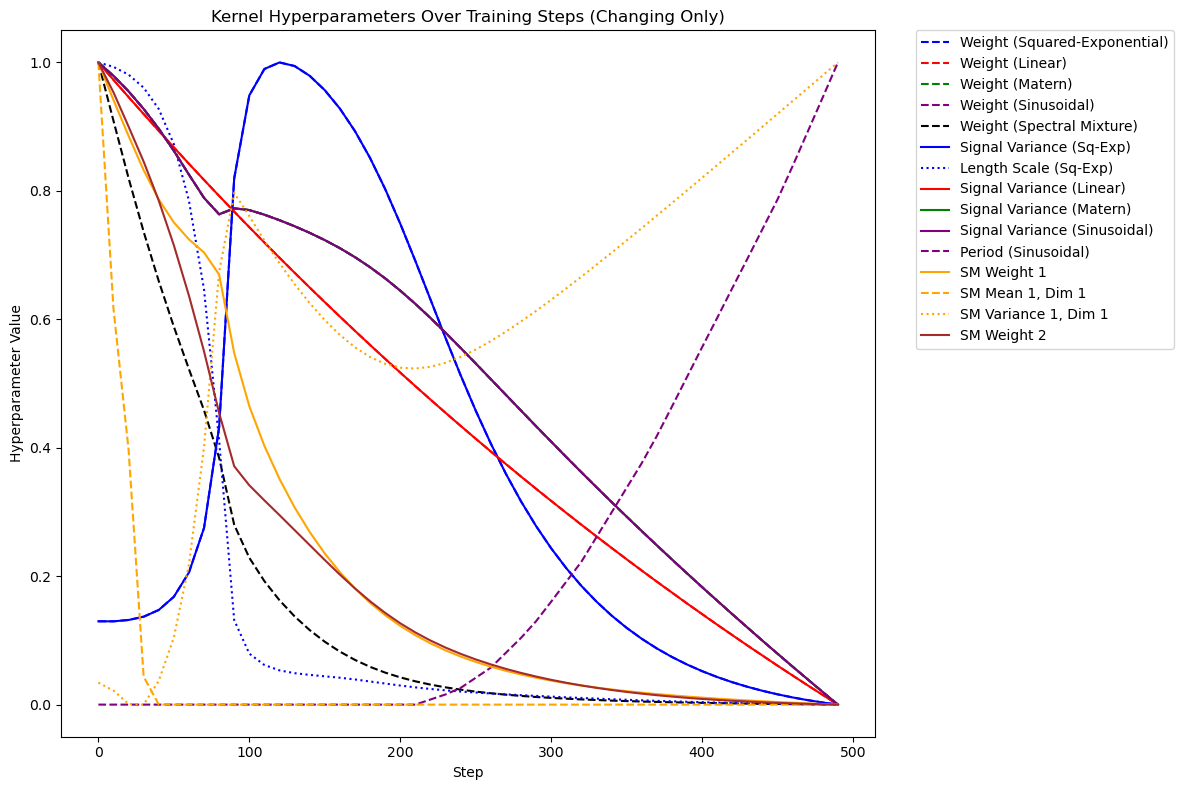

In [12]:
plot_kernel_hyperparameters(history)

# Test Experiment 2
Test on 100 inducing points.

## Parameter Initialization

In [13]:
# Initialize PRNG
init_prng(0)

# Initialize inducing points as a subset of X_train
Z = initialize_inducing_points(X_train, num_inducing=100)

# Initialize hyperparameters in the unconstrained space
unconstrained_hyperparams_init = random_init_combined_hyperparams(X_train)

## Define the Optimization Loop for ELBO

In [14]:
# Set the gradient ascent step size and number of steps
step_size = 5e-3
num_steps = 500

# Optimize ELBO using the empirical Bayes function
optimized_hyperparams, final_elbo, history = empirical_bayes(X_train, Y_train, Z, unconstrained_hyperparams_init, step_size, num_steps)

print("Optimized Hyperparameters:", optimized_hyperparams)
print("Final ELBO Value:", final_elbo)

Step 0, ELBO: -254.50690888368567
Step 10, ELBO: -238.03549021354956
Step 20, ELBO: -222.81248626440583
Step 30, ELBO: -208.78118248745614
Step 40, ELBO: -195.6646015217273
Step 50, ELBO: -183.42982869709277
Step 60, ELBO: -171.66377429252208
Step 70, ELBO: -158.1076648820014
Step 80, ELBO: -139.3540452368843
Step 90, ELBO: -122.1139416605385
Step 100, ELBO: -106.29365698209935
Step 110, ELBO: -91.10650287466625
Step 120, ELBO: -76.45088505263776
Step 130, ELBO: -62.41016925434819
Step 140, ELBO: -49.15005206629485
Step 150, ELBO: -36.890228176534364
Step 160, ELBO: -25.88117661383461
Step 170, ELBO: -16.367129771657943
Step 180, ELBO: -8.532053527269255
Step 190, ELBO: -2.4412594504168794
Step 200, ELBO: 1.9953425441083539
Step 210, ELBO: 5.012616406980015
Step 220, ELBO: 6.93123899672085
Step 230, ELBO: 8.079697365426824
Step 240, ELBO: 8.734453062720718
Step 250, ELBO: 9.09580315355305
Step 260, ELBO: 9.292971431096845
Step 270, ELBO: 9.402262709106282
Step 280, ELBO: 9.465873026031

In [15]:
# Total noise variance
total_noise = np.sum(np.array([optimized_hyperparams[i] for i in [5, 8, 10, 13, 17]]))
print("\nTotal noise:", total_noise)


Total noise: 0.0050853244


## Predict and Plot the Results

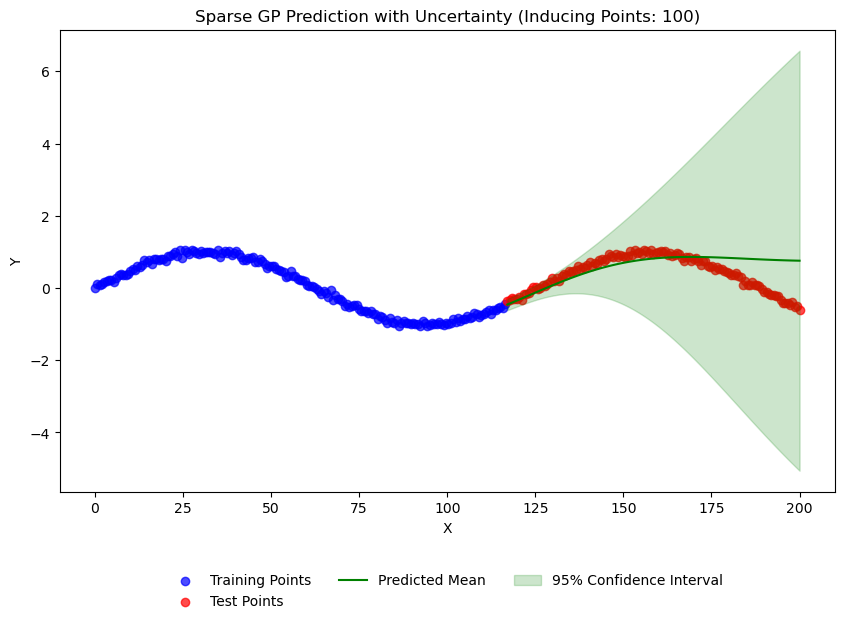

In [16]:
plot_sparse_gp_with_uncertainty(X_train, Y_train, X_test, Y_test, Z, optimized_hyperparams, sparse_gp_posterior_predictive, False)

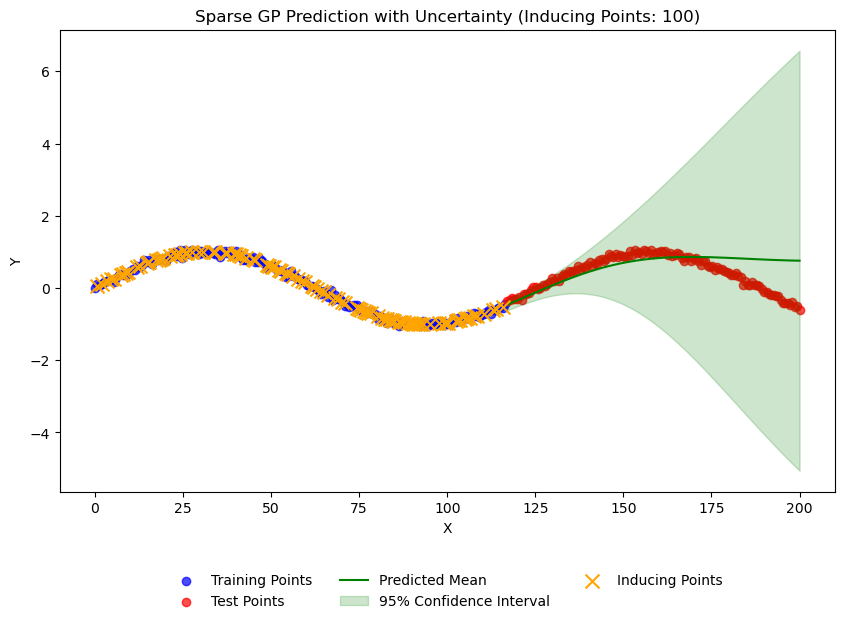

In [17]:
plot_sparse_gp_with_uncertainty(X_train, Y_train, X_test, Y_test, Z, optimized_hyperparams, sparse_gp_posterior_predictive)

In [18]:
# Extract weights
weights = optimized_hyperparams[:5]
weight_percentages = (weights / np.sum(weights)) * 100

# Print the weights
print("Kernel Weights:")
print(f"Kernel 1 (Squared-Exponential): {weights[0]:.4f}")
print(f"Kernel 2 (Linear): {weights[1]:.4f}")
print(f"Kernel 3 (Matérn): {weights[2]:.4f}")
print(f"Kernel 4 (Sinusoidal): {optimized_hyperparams[3]:.4f}")
print(f"Kernel 5 (Spectral Mixture): {optimized_hyperparams[4]:.4f}")

# Print weights as percentages for each kernel
print("\nKernel Weights as Percentages:")
print(f"Kernel 1 (Squared-Exponential): {weight_percentages[0]:.2f}%")
print(f"Kernel 2 (Linear): {weight_percentages[1]:.2f}%")
print(f"Kernel 3 (Matérn): {weight_percentages[2]:.2f}%")
print(f"Kernel 4 (Sinusoidal): {weight_percentages[3]:.2f}%")
print(f"Kernel 5 (Spectral Mixture): {weight_percentages[4]:.2f}%")

# Print other hyperparameters for each kernel
print("\nOther Hyperparameters:")
print(f"Kernel 1 - Noise Variance: {optimized_hyperparams[5]:.4f}")
print(f"Kernel 1 - Signal Variance: {optimized_hyperparams[6]:.4f}")
print(f"Kernel 1 - Length Scale: {optimized_hyperparams[7]:.4f}")
print(f"Kernel 2 - Noise Variance: {optimized_hyperparams[8]:.4f}")
print(f"Kernel 2 - Signal Variance: {optimized_hyperparams[9]:.4f}")
print(f"Kernel 3 - Noise Variance: {optimized_hyperparams[10]:.4f}")
print(f"Kernel 3 - Signal Variance: {optimized_hyperparams[11]:.4f}")
print(f"Kernel 3 - Length Scale: {optimized_hyperparams[12]:.4f}")
print(f"Kernel 4 - Noise Variance: {optimized_hyperparams[13]:.4f}")
print(f"Kernel 4 - Signal Variance: {optimized_hyperparams[14]:.4f}")
print(f"Kernel 4 - Period: {optimized_hyperparams[15]:.4f}")
print(f"Kernel 4 - Length Scale: {optimized_hyperparams[16]:.4f}")
print(f"Kernel 5 - Noise Variance: {optimized_hyperparams[17]:.4f}")

# Print rest of the hyperparameters for the spectral mixture kernel
dim = X_train.shape[1]
i = 18
mixture_count = 1
while i < len(optimized_hyperparams):
    print(f"\nSpectral Mixture Kernel - Mixture {mixture_count}:")
    print(f"Weight: {optimized_hyperparams[i: i + 1][0]:.4f}")
    print(f"Means: {optimized_hyperparams[i + 1: i + 1 + dim]}")
    print(f"Variances: {optimized_hyperparams[i + 1 + dim: i + 1 + 2 * dim]}")
    i += 1 + 2 * dim
    mixture_count += 1
#

print(optimized_hyperparams)

Kernel Weights:
Kernel 1 (Squared-Exponential): 1.4220
Kernel 2 (Linear): 0.5354
Kernel 3 (Matérn): 0.8696
Kernel 4 (Sinusoidal): 0.8696
Kernel 5 (Spectral Mixture): 0.0037

Kernel Weights as Percentages:
Kernel 1 (Squared-Exponential): 38.43%
Kernel 2 (Linear): 14.47%
Kernel 3 (Matérn): 23.50%
Kernel 4 (Sinusoidal): 23.50%
Kernel 5 (Spectral Mixture): 0.10%

Other Hyperparameters:
Kernel 1 - Noise Variance: 0.0010
Kernel 1 - Signal Variance: 3.8654
Kernel 1 - Length Scale: 4312.9038
Kernel 2 - Noise Variance: 0.0010
Kernel 2 - Signal Variance: 1.4553
Kernel 3 - Noise Variance: 0.0010
Kernel 3 - Signal Variance: 2.3637
Kernel 3 - Length Scale: 22026.4648
Kernel 4 - Noise Variance: 0.0010
Kernel 4 - Signal Variance: 2.3637
Kernel 4 - Period: 22026.4648
Kernel 4 - Length Scale: 2.7151
Kernel 5 - Noise Variance: 0.0010

Spectral Mixture Kernel - Mixture 1:
Weight: 0.0770
Means: [1.495]
Variances: [35.874737]

Spectral Mixture Kernel - Mixture 2:
Weight: 0.1290
Means: [2.8812811]
Variances

## NLPD

In [19]:
train_nlpd = calculate_nlpd(X_train, Y_train, Z, optimized_hyperparams, sparse_gp_posterior_predictive, X_train, Y_train)
test_nlpd = calculate_nlpd(X_test, Y_test, Z, optimized_hyperparams, sparse_gp_posterior_predictive, X_train, Y_train)

print(f"Train NLPD: {train_nlpd:.4f}")
print(f"Test NLPD: {test_nlpd:.4f}")

Train NLPD: -1.2521
Test NLPD: 2.2295


## MSE

In [20]:
Y_pred, _ = sparse_gp_posterior_predictive(X_test, X_train, Y_train, Z, optimized_hyperparams)
mse = calculate_mse(Y_test, Y_pred) 
print(f"MSE: {mse:.4f}")

MSE: 0.2320


## ELBO Maximization


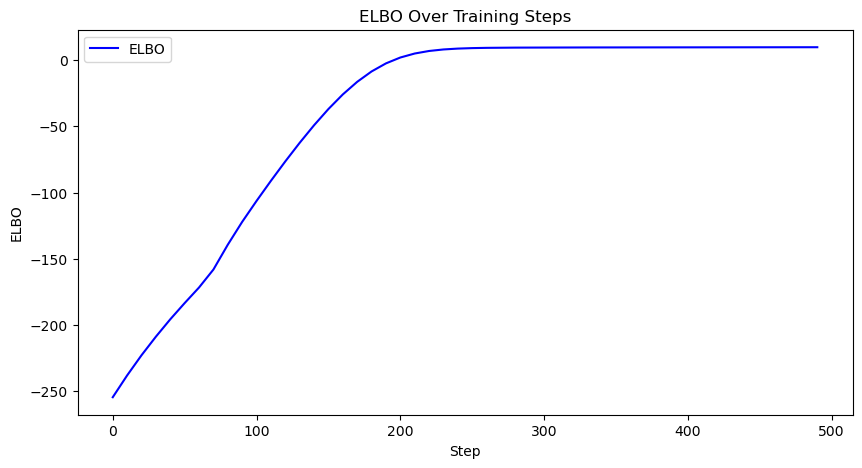

In [21]:
plot_elbo(history)

## Kernel Hyperparameters

Unchanged Hyperparameters:
 - Length Scale (Matern)
 - Length Scale (Sinusoidal)
 - SM Mean 2, Dim 1
 - SM Variance 2, Dim 1
 - SM Weight 3
 - SM Mean 3, Dim 1
 - SM Variance 3, Dim 1
 - SM Weight 4
 - SM Mean 4, Dim 1
 - SM Variance 4, Dim 1
 - SM Weight 5
 - SM Mean 5, Dim 1
 - SM Variance 5, Dim 1
 - SM Weight 6
 - SM Mean 6, Dim 1
 - SM Variance 6, Dim 1
 - SM Weight 7
 - SM Mean 7, Dim 1
 - SM Variance 7, Dim 1
 - SM Weight 8
 - SM Mean 8, Dim 1
 - SM Variance 8, Dim 1
 - SM Weight 9
 - SM Mean 9, Dim 1
 - SM Variance 9, Dim 1
 - SM Weight 10
 - SM Mean 10, Dim 1
 - SM Variance 10, Dim 1


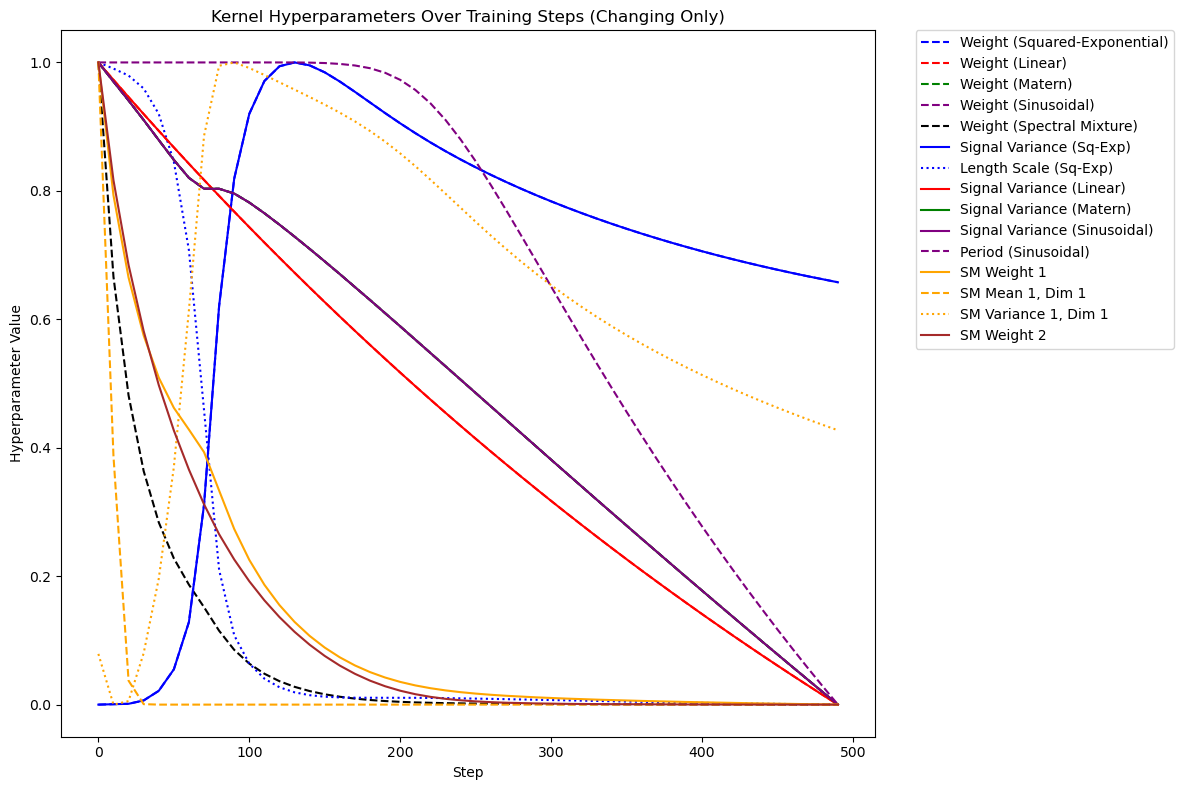

In [22]:
plot_kernel_hyperparameters(history)